In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
import itertools

# Modified bessel function of the first kind
from scipy.special import iv
from scipy.optimize import curve_fit

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall, discretizeTrajectory

# Update source files before running each cell
%load_ext autoreload
%autoreload 2

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


In [2]:
dataFile = '/home/jack/Workspaces/data/ant_simulation/bounded_test_dataset_true.h5'

minimumLength = 5 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = None # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Loading SLEAP data: 100%|██████████████████████| 50/50 [00:00<00:00, 140.86it/s]

Loaded 50 segments!


In [3]:
padding = 15 # mm
inversePadding = None

noWallDataArr, noWallTimeArr, noWallMetadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Removing trajectories near walls: 100%|█████████| 50/50 [01:20<00:00,  1.61s/it]

Loaded 1541 segments!


As is emphasized in many other parts of this project, discretizing a continuous trajectory is a very subjective process, so you need to be very careful in choosing your parameters. As such, here we survey a range of parameters, principally the colinearity threshold (`c`) and the velocity threshold (`velocityThreshold`).

In [4]:
# Convert to discrete steps
# Given as a colinearity value, between [0, 1]
cArr = np.linspace(0.2, 0.99, 2)
cArr = [np.cos(np.pi/4)]

# The minimum velocity that we use to identify waiting
# periods, in mm/s
velocityThresholdArr = np.linspace(0, 10, 2)
velocityThresholdArr = [5] # mm/s

# These two arrays give values of each individual parameter
# so the total number of samples is the product of their lengths.

# These parameters are not as important as the ones above, but still
# should be given adequate thought
minDistancePerRun = 5 # mm
minStepsPerRun = 5 # frames

discreteDataArr = []
discreteStepSizeArr = []
waitTimeArr = []
runTimeArr = []

# Since we have two parameters, we should generate
# each pair of parameters.
allParams = np.array(list(itertools.product(cArr, velocityThresholdArr)))

# Replace the above lists
cArr = allParams.T[0]
velocityThresholdArr = allParams.T[1]

for i in range(len(cArr)):
    discreteDataArr.append([])
    discreteStepSizeArr.append([])
    waitTimeArr.append([])
    runTimeArr.append([])

    for j in tqdm(range(len(dataArr))):
        discreteTraj, waitingTimes, runTimes = discretizeTrajectory(dataArr[j],
                                                                    c=cArr[i],
                                                                    velocityThreshold=velocityThresholdArr[i],
                                                                    dt=1/metadataArr[j]["fps"],
                                                                    minSteps=minStepsPerRun,
                                                                    minDistancePerRun=minDistancePerRun,
                                                                    debug=False)
        discreteDataArr[-1].append(discreteTraj)
        
        discreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
        waitTimeArr[-1].append(waitingTimes)
        runTimeArr[-1].append(runTimes)

noWallDiscreteDataArr = []
noWallDiscreteStepSizeArr = []
noWallWaitTimeArr = []
noWallRunTimeArr = []

for i in range(len(cArr)):
    noWallDiscreteDataArr.append([])
    noWallDiscreteStepSizeArr.append([])
    noWallWaitTimeArr.append([])
    noWallRunTimeArr.append([])

    for j in tqdm(range(len(noWallDataArr))):
        discreteTraj, waitingTimes, runTimes = discretizeTrajectory(noWallDataArr[j],
                                                                    c=cArr[i],
                                                                    velocityThreshold=velocityThresholdArr[i],
                                                                    dt=1/noWallMetadataArr[j]["fps"],
                                                                    minSteps=minStepsPerRun,
                                                                    minDistancePerRun=minDistancePerRun,
                                                                    debug=False)
        noWallDiscreteDataArr[-1].append(discreteTraj)
        
        noWallDiscreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
        noWallWaitTimeArr[-1].append(waitingTimes)
        noWallRunTimeArr[-1].append(runTimes)

  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/jack/Workspaces/python/tracker/notebooks/../tracker/discretize.py:123: RuntimeWarning: invalid value encountered in divide
  absoluteAngleArr = np.arctan2(*(originalStepDirectionArr.T / np.sqrt(np.sum(originalStepDirectionArr**2, axis=-1))))
/home/jack/Workspaces/python/tracker/notebooks/../tracker/discretize.py:226: RuntimeWarning: invalid value encountered in divide
  currentRunDirection /= np.sqrt(np.sum(currentRunDirection**2))
100%|███████████████████████████████████████| 1541/1541 [00:43<00:00, 35.40it/s]


## Turn angle distribution

In [5]:
def computeAngles(trajectory, dt=1, minVelocityThreshold=0):
    # Compute the velocity for the trajectory
    velocityArr = (trajectory[1:] - trajectory[:-1]) / dt
    velocityMagnitudes = np.sqrt(np.sum(velocityArr**2, axis=-1))

    velocityArr = velocityArr[velocityMagnitudes > minVelocityThreshold]
    velocityMagnitudes = velocityMagnitudes[velocityMagnitudes > minVelocityThreshold]

    # Make unit vectors
    velocityArr[:,0] = velocityArr[:,0] / velocityMagnitudes
    velocityArr[:,1] = velocityArr[:,1] / velocityMagnitudes

    # Now take angle differences for the steps
    # The clip is to avoid numerical errors
    angleDifferenceArr = np.array([np.arccos(np.clip(np.dot(velocityArr[i], velocityArr[i+1]), -1., 1.)) for i in range(len(velocityArr)-1)])

    # To compute the sign of the angle, we need
    # to use the cross product
    signArr = np.array([np.sign(np.cross(velocityArr[i], velocityArr[i+1])) for i in range(len(velocityArr)-1)])
    angleDifferenceArr = angleDifferenceArr * signArr
    
    return angleDifferenceArr[~np.isnan(angleDifferenceArr)]

In [6]:
# Convert to discrete steps
fps = metadataArr[0]["fps"]

angleArr = []
noWallAngleArr = []

for i in range(len(cArr)):
    angleArr.append([])
    noWallAngleArr.append([])

    for j in tqdm(range(len(dataArr))):
        discreteData = discreteDataArr[i][j] 

        angles = computeAngles(discreteData,
                               dt=1/fps,
                               minVelocityThreshold=velocityThresholdArr[i])

        angleArr[-1].append(angles)

    for j in tqdm(range(len(noWallDataArr))):
        discreteData = noWallDiscreteDataArr[i][j] 

        angles = computeAngles(discreteData,
                               dt=1/fps,
                               minVelocityThreshold=velocityThresholdArr[i])

        noWallAngleArr[-1].append(angles)

100%|█████████████████████████████████████| 1541/1541 [00:00<00:00, 6126.69it/s]


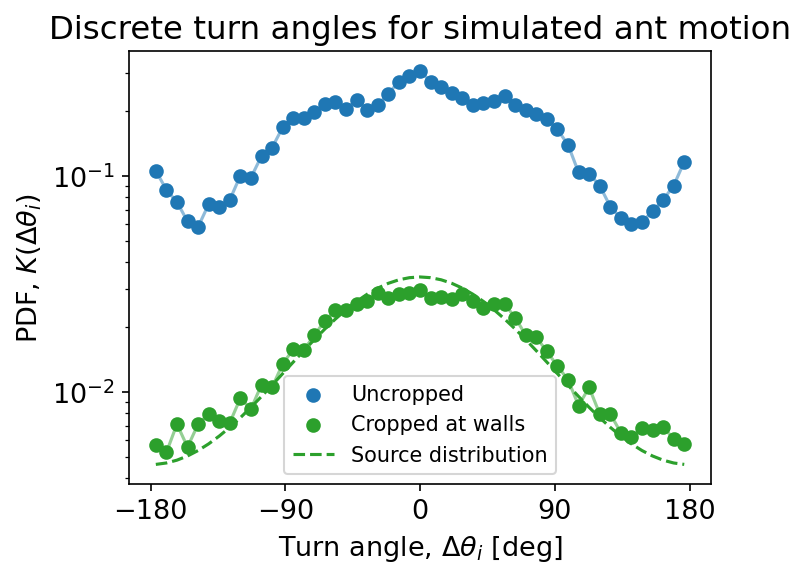

In [17]:
# von Mises distribution that we use to fit sigma, essentially
# a normal distribution just on a periodic domain.
def vonMises(x, k):
    """
    The von Mises distribution.
    """
    # iv is the modified bessel function of the first kind,
    # where we set the order to zero.
    # We explicitly set the center of the distribution to zero
    return np.exp(k * np.cos(x)) / (2 * np.pi * iv(0, k))

numBins = 51

bins = np.linspace(-np.pi, np.pi, numBins+1)
#bins = np.logspace(-1, np.log10(maxDistance), numBins+1)
binArr = (bins[1:] + bins[:-1])/2

colors = ['tab:blue', 'tab:green']

for i in range(len(cArr)):
    # Flatten each trajectory so we can take a histogram
    # of every combined segment
    angles = np.array([a for aa in angleArr[i] for a in aa])
    noWallAngles = np.array([a for aa in noWallAngleArr[i] for a in aa])

    #angles[angles == 0] = np.nan
    
    meanDist, meanBins = np.histogram(angles, bins=bins, density=True)
#    plt.scatter(binArr, meanDist, c=colors[0], label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$')#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
    plt.scatter(binArr * 180/np.pi, meanDist, c=colors[0], label=f'Uncropped')#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
    plt.plot(binArr * 180/np.pi, meanDist, '-', alpha=0.5, c=colors[0])
    
    meanDist, meanBins = np.histogram(noWallAngles, bins=bins, density=True)
#    plt.scatter(binArr, meanDist - 0.5, c=colors[1], label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$')#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
    plt.scatter(binArr * 180/np.pi, meanDist * 1e-1, c=colors[1], label=f'Cropped at walls')#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')
    plt.plot(binArr * 180/np.pi, meanDist * 1e-1, '-', alpha=0.5, c=colors[1])
    
k = 1.0
plt.plot(binArr * 180/np.pi, vonMises(binArr, k) * 1e-1, '--', c='tab:green', label='Source distribution')
plt.xticks([-180, -90, 0, 90, 180])

plt.yscale('log')
#plt.xscale('log')
plt.ylabel('PDF, $K(\\Delta \\theta_i)$')
#plt.yticks(np.linspace(-0.5, 0.6, 6), ['']*6)
plt.xlabel('Turn angle, $\\Delta \\theta_i$ [deg]')
plt.legend(fontsize=10)
#plt.title('Discrete Turn Angle Distribution for Ant Motion\nUncropped')
plt.title('Discrete turn angles for simulated ant motion')
plt.gcf().set_size_inches((5,3.75))
pltsaveall('simulated/08_DiscreteTurnAngle')
plt.show()

## Fitting turn angle distribution

In [27]:
# We use a von mises distribution to fit, essentially
# a normal distribution just on a periodic domain.
def vonMises(x, mu, k):
    """
    The Von Mises distribution.
    """
    # iv is the modified bessel function of the first kind,
    # where we set the order to zero.
    return np.exp(k * np.cos(x - mu)) / (2 * np.pi * iv(0, k))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


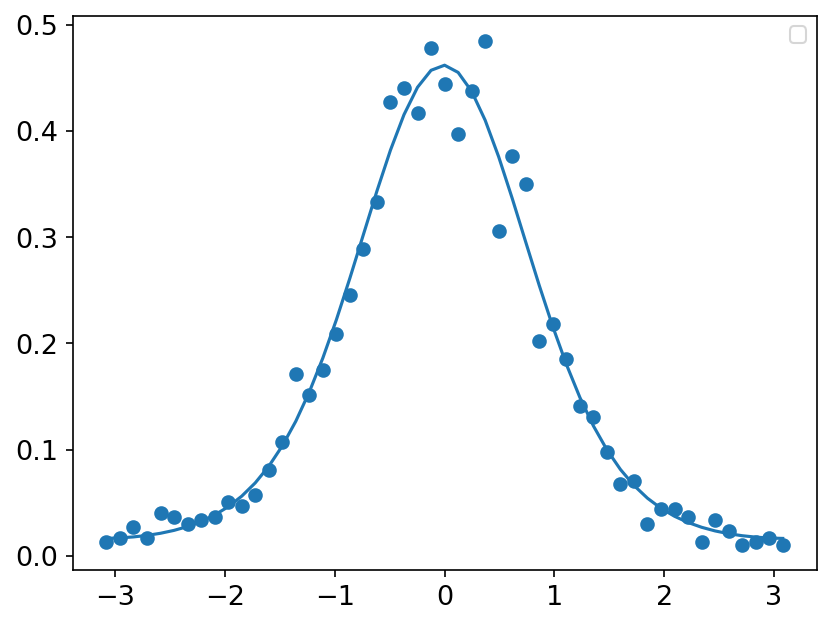

In [28]:
paramArr = np.zeros((len(cArr), 2))

for i in range(len(angleArr)):
    # Flatten each trajectory so we can take a histogram
    # of every combined segment
    angles = np.array([a for aa in noWallAngleArr[i] for a in aa])
    #angles[angles == 0] = np.nan
    
    meanDist, meanBins = np.histogram(angles, bins=bins, density=True)
    meanBins = (meanBins[1:] + meanBins[:-1]) / 2
    
    pOpt, pCov = curve_fit(vonMises, meanBins, meanDist, p0=(0, 1))

    paramArr[i] = pOpt
    plt.plot(meanBins, vonMises(meanBins, pOpt[0], pOpt[1]))
    plt.scatter(meanBins, meanDist)#, label=f'$\\sigma = {metadataArr[0]["angleSigma"]}$, $\\hat \\sigma = {pOpt[1]:.3}$', alpha=0.3)

plt.legend(fontsize=10)
#plt.yscale('log')
plt.show()

In [29]:
paramArr

array([[-0.01061941,  1.66712523]])

TypeError: Dimensions of C (2, 1) should be one smaller than X(2) and Y(1) while using shading='flat' see help(pcolor)

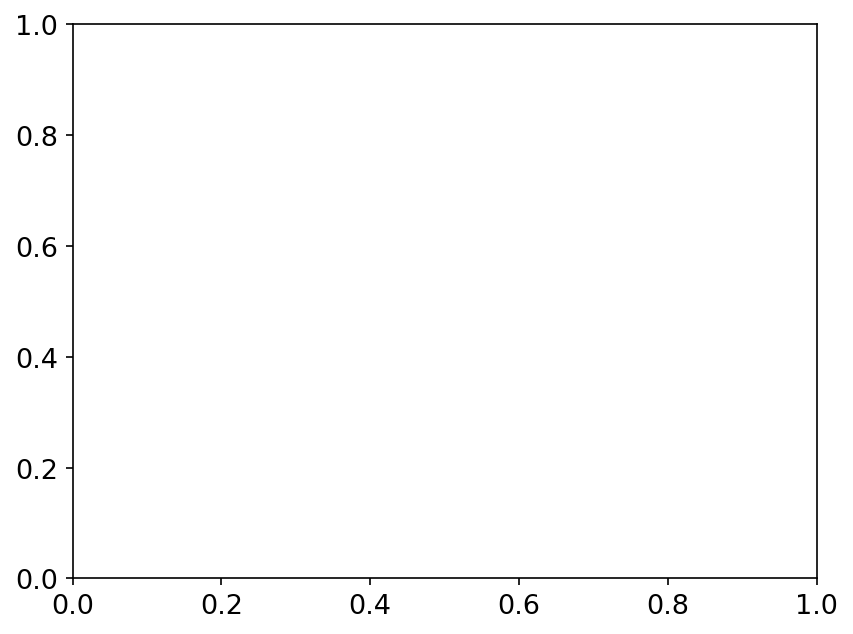

In [20]:
uniqueCArr = np.unique(cArr)
uniqueVArr = np.unique(velocityThresholdArr)

kMatrix = -paramArr[:,1].reshape((len(uniqueCArr), len(uniqueVArr)))

plt.pcolor(uniqueCArr, uniqueVArr, kMatrix)
plt.colorbar(label='Von Mises distribution width, $k$')
#plt.xticks(uniqueCArr)
plt.yticks(uniqueVArr)
plt.xlabel('Colinearity threshold, $c$')
plt.ylabel('Velocity threshold, $v_m$ [mm/s]')
plt.title('Width of Turn Angle Distribution\nBased on Discretization Parameters')
plt.show()